In [1]:
import os
import sys
## Emily's path to misloc package
module_path = os.path.abspath(os.path.join('..' , '..'))
## Harrison's path to misloc package
#module_path = os.path.abspath(os.path.join(
    #'/Users',
    #'chair',
    # 'Documents',
    # 'Academia',
    # 'SuperRes',
    # 'Biteen_colab',
    # 'Mispolarization',
    # 'python',b
    # ))
## Needed for both paths
sys.path.append(module_path)

## Emily's package name
from misloc_package.parameterize import displaced_osc_model as dom
## Harrison's package name
#from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

Plot parameters

In [3]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


Load data 

In [4]:
path_to_mol_data = os.path.join('..', 'data')

#Data file should have first column as energy (eV) and second column is area normalized intensity
emily_data_flip = np.loadtxt(
    os.path.join(path_to_mol_data, 'H-1-slow-pf.csv'), 
#     skiprows=0, 
    delimiter=','
    )
emily_data = emily_data_flip[::-1]

## Some useful functions
def norm_spec(spec):
    return spec/spec.max()

# def nm_to_ev_correct(spec):
#     return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [5]:
def int_norm(y, x=emily_data.T[0]):
    return y / int.trapz(y, x)

In [6]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model = int_norm(model, hbar_omegas)
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return (model - data) * model 

In [7]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

## Find a 'physical' looking guess 

In [8]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.6
ini_script_d = [1.75, 2.5]
ini_hbar_omega_0 = [0.132, .018]
ini_hbar_gamma = .017
T = 294

t_bound = 250
t_points = 700

## New 06/02
## Sort initial guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])

ini_guess_inst = model_from_params(fit_ini_guess, num_modes=2, temp=T)


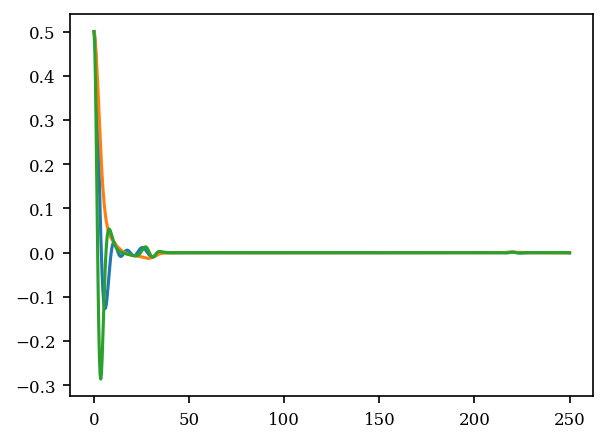

In [9]:
## Plot integrand
ts, ini_2_mode_integrands = ini_guess_inst.emission_lineshape(
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 3)/hbar,
#     mode_idx,
    t_bound = t_bound,
    t_points = t_points, 
    return_integrand=True)

for integ in ini_2_mode_integrands:
    plt.plot(ts, integ)
    

In [23]:
## Set Morse potential parameters
alpha_test = 0.091
depth_test = 45*1.5
basis_size = 20
cumulant_order = 4
#A matrix order must be AT LEAST Cumulant order +1
A_matrix_order = 7

morse_ground = dom.lambda_generator_Morse(alpha_test, depth_test)
## Build polynomial prefactors for electronic ground state
mm_lam_g_0 = morse_ground
## If you want a harmonic ground state, uncomment:
# mm_lam_g_0 = np.zeros_like(morse_ground)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0) ## zeros means harmonic

## Build polynomial prefactors for electronic excited state
mm_lam_e_0 = dom.displaced_lambdas(morse_ground, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

## Combines the lambda arrays according to implementation 
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

## Build emission model object (from class)
multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    ## Order of A matrix must be AT LEAST Cumulant order +1
    A_mat_order=A_matrix_order,
    )

## Defining the frequency domain to compute spectra
hw_domain = (
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 100)
    - ini_hbar_omega_eg_0
    )
## Build lineshape from model instance
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain,
    ## Default Cumulant is now 5, which is different then before 06/02/20
    cumulant_trunc_order=cumulant_order)

## Build lineshape components
# mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=0)
# mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=1)

Make dee plots

In [24]:
## Build lineshape from model instance
mm_lineshape_c6 = multimode_test_inst.emission_lineshape(
    hw_domain,
    ## Default Cumulant is now 5, which is different then before 06/02/20
    cumulant_trunc_order=6)

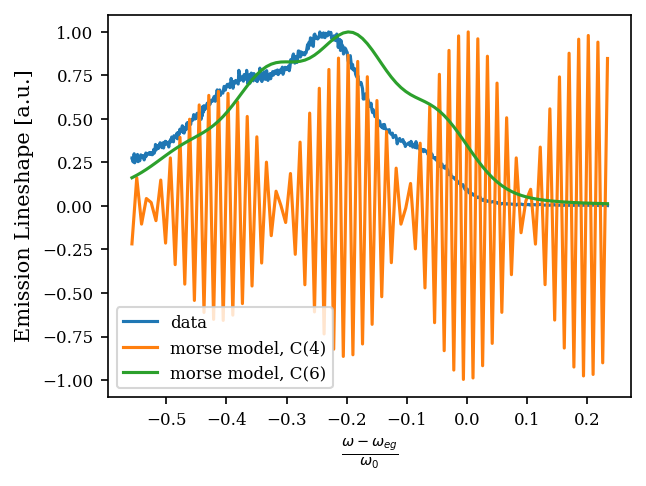

In [25]:
## Data (gets shifted by the assumed hw_eg0)
plt.plot(
    emily_data.T[0] - ini_hbar_omega_eg_0, 
    norm_spec(emily_data.T[1]), 
    label='data')

## Plot anharmonic model with cumulants up to 5th
plt.plot(
    hw_domain, 
    norm_spec(mm_lineshape*2*np.pi/3), 
    label='morse model, C(4)')

## Plot anharmonic model with cumulants up to 6th
plt.plot(
    hw_domain, 
    norm_spec(mm_lineshape_c6*2*np.pi/3), 
    label='morse model, C(6)')

## Label axis and create legend and pretty stuff
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

(0, 4e-14)

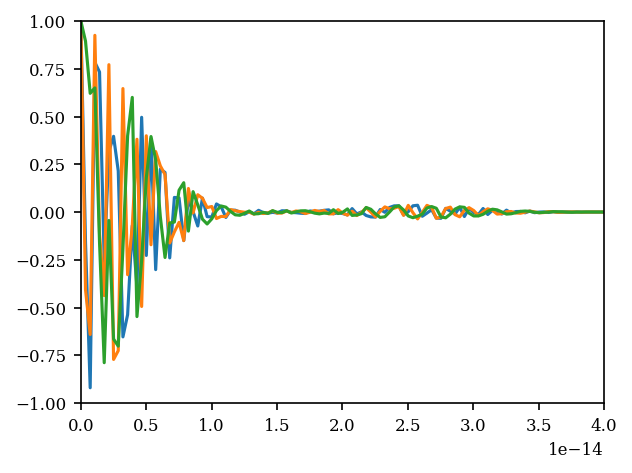

In [26]:
## Plot integrand
ts, ini_2_mode_integrands = multimode_test_inst.emission_lineshape(
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 3)/hbar,
#     mode_idx,
#     t_bound = t_bound,
#     t_points = t_points, 
    return_integrand=True)

for integ in ini_2_mode_integrands:
    plt.plot(ts, integ)
    
plt.ylim([-1, 1])
plt.xlim([0, 40e-15])

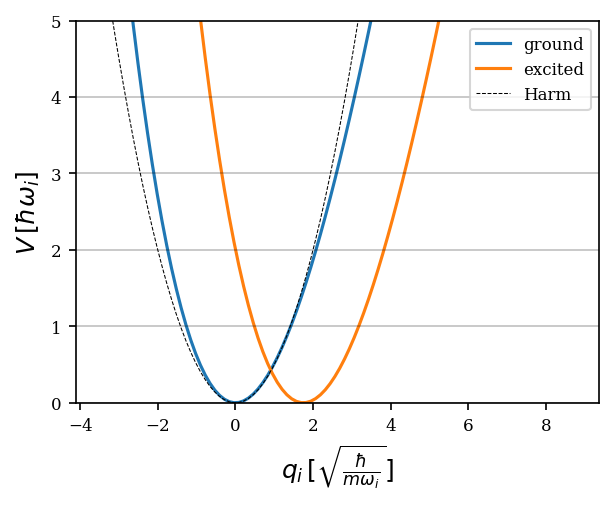

In [14]:
## Plot potential surfaces for 0th mode
## ~~~~~~~~~~~~~~~

## Generate displacement axis
pot_xs = np.linspace(-2, 5, 100) * ini_script_d[0]

## Ground and excited surfaces
Vg_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_g_0)
Ve_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_e_0)

## Plot harmonic surface for reference
Vh_of_x = dom.poly_from_lambdas(pot_xs, np.zeros(3))

plt.plot(
    pot_xs, Vg_of_x, 
    label='ground')
plt.plot(
    pot_xs, 
    (
        Ve_of_x 
#         + 
#         ini_hbar_omega_eg_0/ini_hbar_omega_0[0]
        ), 
    label='excited')
plt.plot(
    pot_xs, 
    Vh_of_x, 
    label='Harm', 
    ls = '--', 
    c='k', 
    lw=.5)

plt.ylabel('$V \,[\hbar\omega_i]$')
plt.xlabel(r'$q_i \,[\sqrt{\frac{\hbar}{m\omega_i}}]$')
plt.ylim([0,5])
plt.legend()

## If you want to drawy lines
for i in np.arange(round(plt.gca().get_ylim()[1])):
    plt.axhline(i, lw=.2, c='k')

In [27]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.65
ini_script_d = [1.75, 2.5]
ini_hbar_omega_0 = [0.132, .018]
ini_hbar_gamma = .017
T = 294

t_bound = 250
t_points = 700

## New 06/02
## Sort initial guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])

ini_guess_inst = model_from_params(fit_ini_guess, num_modes=2, temp=T)

## ini. guess lineshape
ini_2_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = t_bound,
    t_points = t_points)

In [28]:
## Set Morse potential parameters
alpha_test = 0.34
depth_test = 8
basis_size = 20
cumulant_order = 5
#A matrix order must be AT LEAST Cumulant order +1
A_matrix_order = 7

morse_ground = dom.lambda_generator_Morse(alpha_test, depth_test)
## Build polynomial prefactors for electronic ground state
mm_lam_g_0 = morse_ground
## If you want a harmonic ground state, uncomment:
# mm_lam_g_0 = np.zeros_like(morse_ground)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0) ## zeros means harmonic

## Build polynomial prefactors for electronic excited state
mm_lam_e_0 = dom.displaced_lambdas(morse_ground, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

## Combines the lambda arrays according to implementation 
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

## Build emission model object (from class)
multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    ## Order of A matrix must be AT LEAST Cumulant order +1
    A_mat_order=A_matrix_order,
    )

## Defining the frequency domain to compute spectra
hw_domain = (
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 100)
    - ini_hbar_omega_eg_0
    )
## Build lineshape from model instance
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain,
    ## Default Cumulant is now 5, which is different then before 06/02/20
    cumulant_trunc_order=cumulant_order)

## Build lineshape components
# mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=0)
# mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=1)

Make dee plots

In [31]:
# # Build lineshape from model instance
# mm_lineshape_c6 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     ## Default Cumulant is now 5, which is different then before 06/02/20
#     cumulant_trunc_order=6)

C:\Users\emily\Documents\UW\Research\Photocatalysis\Anisole_functionalized\Hydrogen-bonding\Spectral_fit\misloc_package\parameterize\displaced_osc_model.py:1873: RuntimeWarning: overflow encountered in exp
  cum_sum[None, :])
C:\Users\emily\Miniconda3\lib\site-packages\numpy\lib\function_base.py:4062: RuntimeWarning: invalid value encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
C:\Users\emily\Miniconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


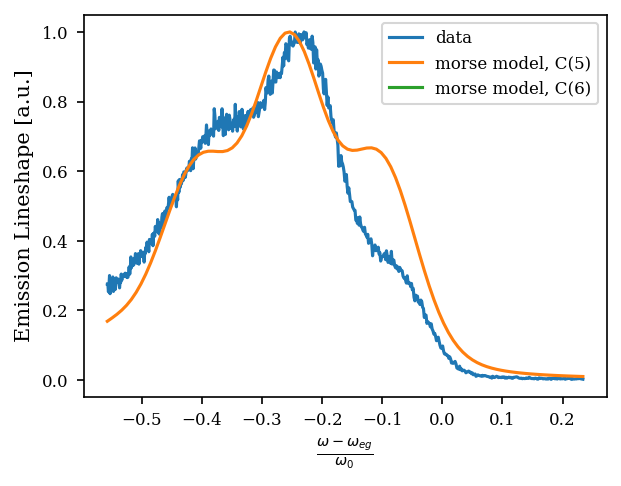

In [32]:
## Data (gets shifted by the assumed hw_eg0)
plt.plot(
    emily_data.T[0] - ini_hbar_omega_eg_0, 
    norm_spec(emily_data.T[1]), 
    label='data')

## Plot anharmonic model with cumulants up to 5th
plt.plot(
    hw_domain, 
    norm_spec(mm_lineshape*2*np.pi/3), 
    label='morse model, C(5)')

# # Plot anharmonic model with cumulants up to 6th
# plt.plot(
#     hw_domain, 
#     norm_spec(mm_lineshape_c6*2*np.pi/3), 
#     label='morse model, C(6)')

## Label axis and create legend and pretty stuff
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

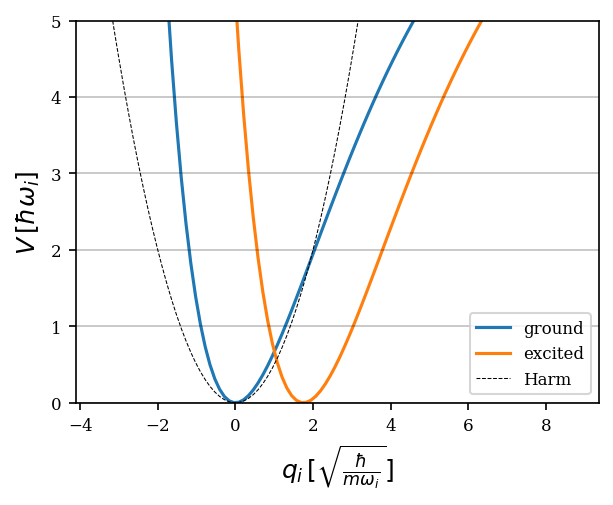

In [33]:
## Plot potential surfaces for 0th mode
## ~~~~~~~~~~~~~~~

## Generate displacement axis
pot_xs = np.linspace(-2, 5, 100) * ini_script_d[0]

## Ground and excited surfaces
Vg_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_g_0)
Ve_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_e_0)

## Plot harmonic surface for reference
Vh_of_x = dom.poly_from_lambdas(pot_xs, np.zeros(3))

plt.plot(
    pot_xs, Vg_of_x, 
    label='ground')
plt.plot(
    pot_xs, 
    (
        Ve_of_x 
#         + 
#         ini_hbar_omega_eg_0/ini_hbar_omega_0[0]
        ), 
    label='excited')
plt.plot(
    pot_xs, 
    Vh_of_x, 
    label='Harm', 
    ls = '--', 
    c='k', 
    lw=.5)

plt.ylabel('$V \,[\hbar\omega_i]$')
plt.xlabel(r'$q_i \,[\sqrt{\frac{\hbar}{m\omega_i}}]$')
plt.ylim([0,5])
plt.legend()

## If you want to drawy lines
for i in np.arange(round(plt.gca().get_ylim()[1])):
    plt.axhline(i, lw=.2, c='k')

In [27]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.65
ini_script_d = [1.75, 2.5]
ini_hbar_omega_0 = [0.132, .018]
ini_hbar_gamma = .017
T = 294

t_bound = 250
t_points = 700

## New 06/02
## Sort initial guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])

ini_guess_inst = model_from_params(fit_ini_guess, num_modes=2, temp=T)

## ini. guess lineshape
ini_2_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = t_bound,
    t_points = t_points)

In [68]:
## Set Morse potential parameters
alpha_test = 0.39
depth_test = 8.1
basis_size = 20
cumulant_order = 5
#A matrix order must be AT LEAST Cumulant order +1
A_matrix_order = 7

morse_ground = dom.lambda_generator_Morse(alpha_test, depth_test)
## Build polynomial prefactors for electronic ground state
mm_lam_g_0 = morse_ground
## If you want a harmonic ground state, uncomment:
# mm_lam_g_0 = np.zeros_like(morse_ground)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0) ## zeros means harmonic

## Build polynomial prefactors for electronic excited state
mm_lam_e_0 = dom.displaced_lambdas(morse_ground, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

## Combines the lambda arrays according to implementation 
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

## Build emission model object (from class)
multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    ## Order of A matrix must be AT LEAST Cumulant order +1
    A_mat_order=A_matrix_order,
    )

## Defining the frequency domain to compute spectra
hw_domain = (
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 100)
    - ini_hbar_omega_eg_0
    )
## Build lineshape from model instance
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain,
    ## Default Cumulant is now 5, which is different then before 06/02/20
    cumulant_trunc_order=cumulant_order)

## Build lineshape components
# mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=0)
# mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     isolate_mode=1)

Make dee plots

In [69]:
# # Build lineshape from model instance
# mm_lineshape_c6 = multimode_test_inst.emission_lineshape(
#     hw_domain,
#     ## Default Cumulant is now 5, which is different then before 06/02/20
#     cumulant_trunc_order=6)

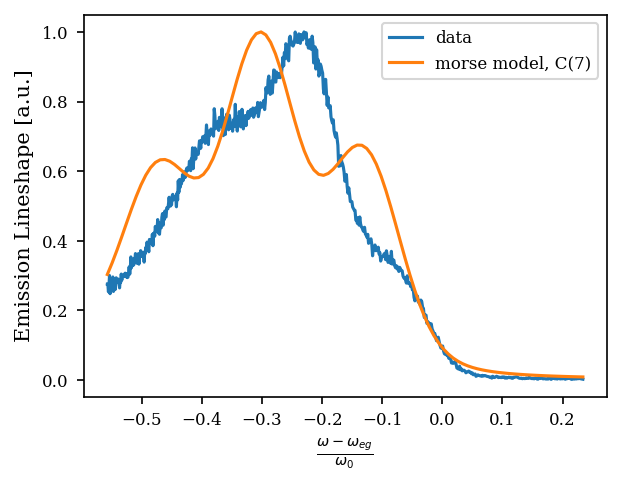

In [70]:
## Data (gets shifted by the assumed hw_eg0)
plt.plot(
    emily_data.T[0] - ini_hbar_omega_eg_0, 
    norm_spec(emily_data.T[1]), 
    label='data')

## Plot anharmonic model with cumulants up to 5th
plt.plot(
    hw_domain, 
    norm_spec(mm_lineshape*2*np.pi/3), 
    label='morse model, C(7)')

# # Plot anharmonic model with cumulants up to 6th
# plt.plot(
#     hw_domain, 
#     norm_spec(mm_lineshape_c6*2*np.pi/3), 
#     label='morse model, C(6)')

## Label axis and create legend and pretty stuff
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

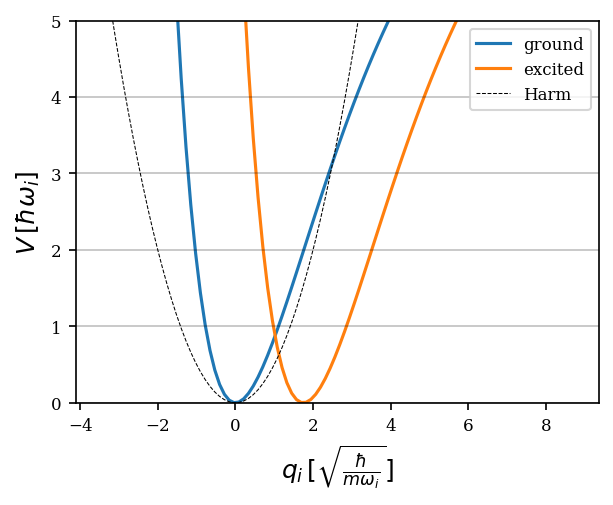

In [71]:
## Plot potential surfaces for 0th mode
## ~~~~~~~~~~~~~~~

## Generate displacement axis
pot_xs = np.linspace(-2, 5, 100) * ini_script_d[0]

## Ground and excited surfaces
Vg_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_g_0)
Ve_of_x = dom.poly_from_lambdas(pot_xs, mm_lam_e_0)

## Plot harmonic surface for reference
Vh_of_x = dom.poly_from_lambdas(pot_xs, np.zeros(3))

plt.plot(
    pot_xs, Vg_of_x, 
    label='ground')
plt.plot(
    pot_xs, 
    (
        Ve_of_x 
#         + 
#         ini_hbar_omega_eg_0/ini_hbar_omega_0[0]
        ), 
    label='excited')
plt.plot(
    pot_xs, 
    Vh_of_x, 
    label='Harm', 
    ls = '--', 
    c='k', 
    lw=.5)

plt.ylabel('$V \,[\hbar\omega_i]$')
plt.xlabel(r'$q_i \,[\sqrt{\frac{\hbar}{m\omega_i}}]$')
plt.ylim([0,5])
plt.legend()

## If you want to drawy lines
for i in np.arange(round(plt.gca().get_ylim()[1])):
    plt.axhline(i, lw=.2, c='k')